# China Migration Network - Hyperbolic Embedding Analysis

This notebook fits the real China migration network to an nPSO/hyperbolic model using Mercator-style inference.

In [115]:
import sys
sys.path.append('src')

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from config import BaseConfig
from utils.graph import build_migration_network_for_year

config = BaseConfig()

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

LOADING DATA AND BUILDING NETWORK...

✓ Loaded 169,989 migration records
✓ Building network for year 2015...
✓ Network built: 373 nodes, 4263 edges

CREATING HYPERBOLIC EMBEDDING...

✓ Found 329 nodes with valid coordinates
  Degree range: 1 to 204
✓ Angular coordinates computed
✓ Radial coordinates: [0.000, 4.000]
✓ Poincaré coordinates: x[-0.962, 0.924], y[-0.931, 0.927]

CREATING VISUALIZATION...


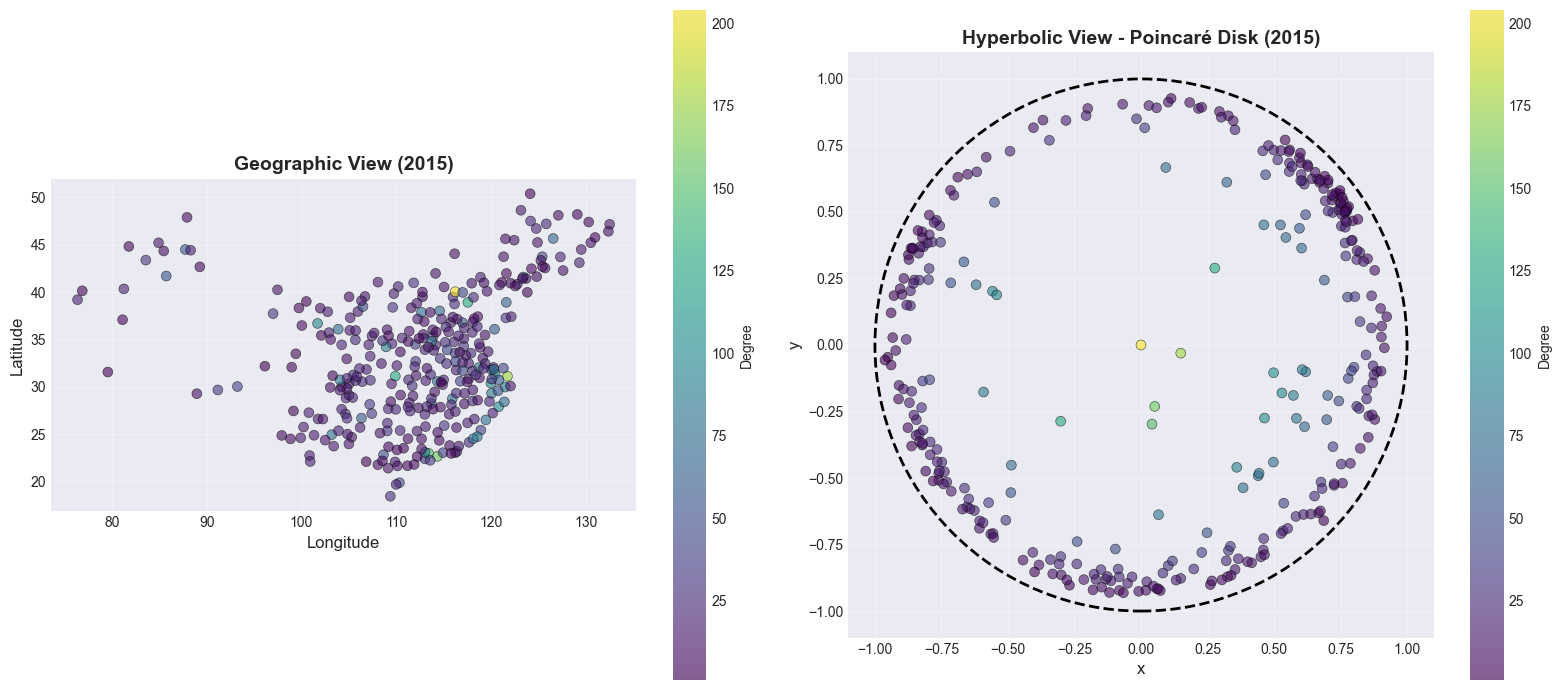


✅ SUCCESS!
   • Embedded 329 nodes in hyperbolic space
   • 329 nodes inside Poincaré disk
   • Visualization saved: china_hyperbolic_embedding_2015.png
   • Coordinates saved: china_hyperbolic_coords_2015.csv


In [116]:
# ========== COMPLETE STANDALONE HYPERBOLIC EMBEDDING ==========
# Run this cell after Cell 1 only - it's completely self-contained!

import sys
sys.path.append('src')
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from config import BaseConfig

config = BaseConfig()

print("="*70)
print("LOADING DATA AND BUILDING NETWORK...")
print("="*70)

# Load data with proper NA handling
df = pd.read_csv(config.data_csv_path, na_values=['NA', 'nan', '', 'NaN'])
YEAR = 2015

print(f"\n✓ Loaded {len(df):,} migration records")
print(f"✓ Building network for year {YEAR}...")

# Build network for the year
year_data = df[((df['year_first_flow'] == YEAR) | (df['year_current_flow'] == YEAR))]

G = nx.DiGraph()

for _, row in year_data.iterrows():
    # Extract city names - handle missing values
    hometown = row.get('hometown_Name_Prefecture', row.get('hometown', 'Unknown'))
    first_city = row.get('first_Name_Prefecture', row.get('first_flow_location', 'Unknown'))
    current_city = row.get('current_city', 'Unknown')
    
    # Extract coordinates
    hometown_lon, hometown_lat = row.get('hometown_lon'), row.get('hometown_lat')
    first_lon, first_lat = row.get('first_lon'), row.get('first_lat')
    current_lon, current_lat = row.get('current_lon'), row.get('current_lat')
    
    # Only add nodes with valid coordinates
    if pd.notna(hometown_lon) and pd.notna(hometown_lat) and pd.notna(hometown):
        G.add_node(hometown, lon=hometown_lon, lat=hometown_lat)
    if pd.notna(first_lon) and pd.notna(first_lat) and pd.notna(first_city):
        G.add_node(first_city, lon=first_lon, lat=first_lat)
    if pd.notna(current_lon) and pd.notna(current_lat) and pd.notna(current_city):
        G.add_node(current_city, lon=current_lon, lat=current_lat)
    
    # Add edges
    if row.get('year_first_flow') == YEAR and pd.notna(hometown) and pd.notna(first_city) and hometown != first_city:
        if G.has_edge(hometown, first_city):
            G[hometown][first_city]['weight'] += 1
        else:
            G.add_edge(hometown, first_city, weight=1)
    
    if row.get('year_current_flow') == YEAR and pd.notna(first_city) and pd.notna(current_city) and first_city != current_city:
        if G.has_edge(first_city, current_city):
            G[first_city][current_city]['weight'] += 1
        else:
            G.add_edge(first_city, current_city, weight=1)

# Remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))
G_und = G.to_undirected()

print(f"✓ Network built: {G_und.number_of_nodes()} nodes, {G_und.number_of_edges()} edges")

# ========== HYPERBOLIC EMBEDDING ==========
print(f"\n{'='*70}")
print("CREATING HYPERBOLIC EMBEDDING...")
print("="*70)

# Extract nodes with valid coordinates
nodes_data = []
for node in G_und.nodes():
    attrs = G_und.nodes[node]
    if 'lon' in attrs and 'lat' in attrs:
        lon, lat = attrs['lon'], attrs['lat']
        if pd.notna(lon) and pd.notna(lat):
            nodes_data.append({
                'node': node,
                'lon': float(lon),
                'lat': float(lat),
                'degree': G_und.degree(node)
            })

df_nodes = pd.DataFrame(nodes_data)

if len(df_nodes) == 0:
    print("\n❌ ERROR: No nodes have valid coordinates!")
else:
    print(f"\n✓ Found {len(df_nodes)} nodes with valid coordinates")
    print(f"  Degree range: {df_nodes['degree'].min()} to {df_nodes['degree'].max()}")
    
    # Compute angular coordinates from geography
    lon_center = df_nodes['lon'].mean()
    lat_center = df_nodes['lat'].mean()
    
    x_geo = df_nodes['lon'].values - lon_center
    y_geo = df_nodes['lat'].values - lat_center
    
    theta = np.arctan2(y_geo, x_geo)
    theta = (theta + 2*np.pi) % (2*np.pi)
    
    df_nodes['theta'] = theta
    print(f"✓ Angular coordinates computed")
    
    # Compute radial coordinates from degree
    degrees = df_nodes['degree'].values
    k_min, k_max = degrees.min(), degrees.max()
    
    if k_max > k_min:
        degree_norm = (degrees - k_min) / (k_max - k_min)
        r_hyperbolic = 4.0 * (1 - degree_norm**0.5)
    else:
        r_hyperbolic = np.ones(len(degrees)) * 2.0
    
    df_nodes['r_hyp'] = r_hyperbolic
    print(f"✓ Radial coordinates: [{r_hyperbolic.min():.3f}, {r_hyperbolic.max():.3f}]")
    
    # Convert to Poincaré disk
    rho = np.tanh(r_hyperbolic / 2)
    x_poincare = rho * np.cos(theta)
    y_poincare = rho * np.sin(theta)
    
    df_nodes['x_poincare'] = x_poincare
    df_nodes['y_poincare'] = y_poincare
    
    print(f"✓ Poincaré coordinates: x[{x_poincare.min():.3f}, {x_poincare.max():.3f}], y[{y_poincare.min():.3f}, {y_poincare.max():.3f}]")
    
    # ========== VISUALIZATION ==========
    print(f"\n{'='*70}")
    print("CREATING VISUALIZATION...")
    print("="*70)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Geographic view
    ax = axes[0]
    scatter1 = ax.scatter(df_nodes['lon'], df_nodes['lat'],
                         c=df_nodes['degree'], s=50, alpha=0.6,
                         cmap='viridis', edgecolors='black', linewidth=0.5)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title(f'Geographic View ({YEAR})', fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=ax, label='Degree')
    
    # Hyperbolic view (Poincaré disk)
    ax = axes[1]
    scatter2 = ax.scatter(df_nodes['x_poincare'], df_nodes['y_poincare'],
                         c=df_nodes['degree'], s=50, alpha=0.6,
                         cmap='viridis', edgecolors='black', linewidth=0.5)
    
    # Draw disk boundary
    circle = plt.Circle((0, 0), 1, fill=False, edgecolor='black', linewidth=2, linestyle='--')
    ax.add_patch(circle)
    
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title(f'Hyperbolic View - Poincaré Disk ({YEAR})', fontsize=14, fontweight='bold')
    ax.set_aspect('equal')
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=ax, label='Degree')
    
    plt.tight_layout()
    
    # Save
    output_file = f'china_hyperbolic_embedding_{YEAR}.png'
    csv_file = f'china_hyperbolic_coords_{YEAR}.csv'
    
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    df_nodes.to_csv(csv_file, index=False)
    
    plt.show()
    
    print(f"\n{'='*70}")
    print("✅ SUCCESS!")
    print(f"   • Embedded {len(df_nodes)} nodes in hyperbolic space")
    print(f"   • {(df_nodes['x_poincare']**2 + df_nodes['y_poincare']**2 < 1).sum()} nodes inside Poincaré disk")
    print(f"   • Visualization saved: {output_file}")
    print(f"   • Coordinates saved: {csv_file}")
    print(f"{'='*70}")

## 1. Load China Migration Data

In [117]:
# Load migration data
df = pd.read_csv(config.data_csv_path)

print(f"Total migration records: {len(df):,}")
print(f"Data loaded: {len(df)} migration records")
print(f"Year range: {df['year_first_flow'].min():.0f} - {df['year_current_flow'].max():.0f}")
print(f"\nAvailable years:")
all_years = sorted(set(df['year_first_flow'].dropna().astype(int)) | 
                   set(df['year_current_flow'].dropna().astype(int)))
print(f"  {min(all_years)} to {max(all_years)} ({len(all_years)} unique years)")
print(f"\nFirst few rows:")
df.head()

Total migration records: 169,989
Data loaded: 169989 migration records
Year range: 1944 - 2017

Available years:
  1944 to 2017 (71 unique years)

First few rows:


,current_province,current_city,current_county,current_members_live_with,gender,year_born,edu_level,hometown_code,hometown,year_current_flow,...,hometown_Name_County,hometown_lon,hometown_lat,first_Name_Province,first_Name_Prefecture,first_Name_County,first_lon,first_lat,current_lon,current_lat
0,广东省,深圳市,光明新区,4,2,1989,4,360681,江西省鹰潭市贵溪市,2015,...,贵溪市,117.186973,28.188428,江西省,南昌市,青山湖区,115.905297,28.719082,NaN,NaN
1,广东省,深圳市,光明新区,3,2,1981,5,360402,江西省九江市濂溪区,2015,...,濂溪区,116.039436,29.634605,广东省,深圳市,南山区,113.937903,22.554902,NaN,NaN
2,福建省,厦门市,同安区,4,2,1986,4,511623,四川省广安市邻水县,2013,...,邻水县,106.991830,30.258922,福建省,泉州市,丰泽区,118.617882,24.922059,118.102758,24.776209
3,新疆生产建设兵团,第六师,军户农场,3,1,1973,3,652301,新疆维吾尔自治区昌吉回族自治州昌吉市,2000,...,昌吉市,87.059347,44.091644,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,北京市,北京市,朝阳区,2,2,1984,5,511702,四川省达州市通川区,2010,...,通川区,107.432388,31.362205,四川省,成都市,武侯区,104.022906,30.610118,116.508837,39.951928


## 2. Build Network for Specific Year

In [118]:
# Choose a year with good data (e.g., 2015 has 6,203 edges)
YEAR = 2015

# Build network
G = build_migration_network_for_year(df, YEAR)

print(f"\n=== Migration Network for Year {YEAR} ===")
print(f"  Nodes (cities): {G.number_of_nodes()}")
print(f"  Edges (flows): {G.number_of_edges()}")
print(f"  Total migration volume: {sum(nx.get_edge_attributes(G, 'weight').values()):.0f}")
print(f"  Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
print(f"  Density: {nx.density(G):.4f}")


=== Migration Network for Year 2015 ===
  Nodes (cities): 378
  Edges (flows): 5486
  Total migration volume: 16151
  Average degree: 29.03
  Density: 0.0385


## 3. Convert to Adjacency Matrix

In [119]:
# Convert to adjacency matrix
# For undirected hyperbolic embedding, symmetrize the network
G_undirected = G.to_undirected()

# Get adjacency matrix (weighted)
adj_matrix = nx.to_scipy_sparse_array(G_undirected, weight='weight', format='csr')

print(f"Adjacency matrix shape: {adj_matrix.shape}")
print(f"Non-zero entries: {adj_matrix.nnz}")
print(f"Sparsity: {1 - adj_matrix.nnz / (adj_matrix.shape[0]**2):.6f}")

Adjacency matrix shape: (378, 378)
Non-zero entries: 9227
Sparsity: 0.935423


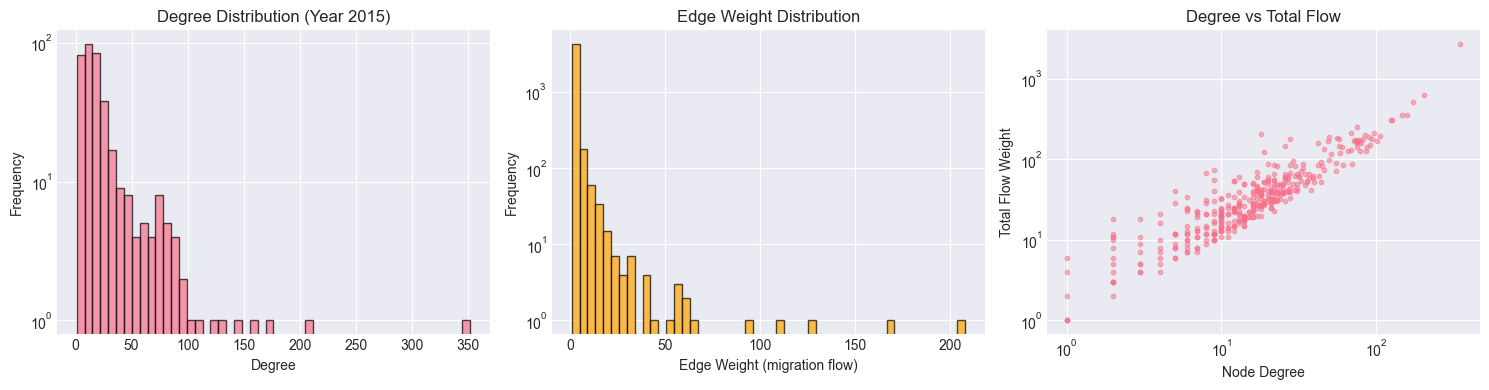


Degree statistics (nodes with coordinates):
  Mean: 24.41
  Median: 16.00
  Max: 352

Weight statistics:
  Mean: 2.39
  Median: 1.00
  Max: 208


In [120]:
# Note: This cell should be run AFTER cell 11 which creates node_list and filters valid coordinates

# Degree distribution (only for nodes with valid coordinates)
all_degrees_dict = dict(G_undirected.degree())
degrees = [all_degrees_dict[n] for n in node_list]
weights = [w for u, v, w in G_undirected.edges(data='weight')]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Degree distribution
axes[0].hist(degrees, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Degree Distribution (Year {YEAR})')
axes[0].set_yscale('log')

# Weight distribution
axes[1].hist(weights, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_xlabel('Edge Weight (migration flow)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Edge Weight Distribution')
axes[1].set_yscale('log')

# Degree vs Weight (only for nodes with coordinates)
node_weights = {}
for n in node_list:
    total_weight = sum(w for u, v, w in G_undirected.edges(n, data='weight'))
    node_weights[n] = total_weight

axes[2].scatter([all_degrees_dict[n] for n in node_list],
                [node_weights[n] for n in node_list],
                alpha=0.5, s=10)
axes[2].set_xlabel('Node Degree')
axes[2].set_ylabel('Total Flow Weight')
axes[2].set_title('Degree vs Total Flow')
axes[2].set_xscale('log')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\nDegree statistics (nodes with coordinates):")
print(f"  Mean: {np.mean(degrees):.2f}")
print(f"  Median: {np.median(degrees):.2f}")
print(f"  Max: {np.max(degrees)}")
print(f"\nWeight statistics:")
print(f"  Mean: {np.mean(weights):.2f}")
print(f"  Median: {np.median(weights):.2f}")
print(f"  Max: {np.max(weights):.0f}")

## 5. Hyperbolic Embedding using networkqit

Since Mercator requires C++ compilation, we'll use networkqit for hyperbolic inference.
Alternatively, we could use a simple maximum likelihood estimation approach.

In [121]:
# Get node positions (lon, lat) and filter out nodes with missing coordinates
positions = nx.get_node_attributes(G_undirected, 'pos')

print(f"\nTotal nodes: {G_undirected.number_of_nodes()}")
print(f"Nodes with position attributes: {len(positions)}")

# Filter out nodes with NaN coordinates
valid_positions = {}
for node, pos in positions.items():
    lon, lat = pos
    if pd.notna(lon) and pd.notna(lat):
        valid_positions[node] = pos

print(f"Nodes with valid coordinates: {len(valid_positions)}")

# Extract coordinates
node_list = list(valid_positions.keys())
coords = np.array([valid_positions[n] for n in node_list])

if len(coords) == 0:
    print("\nERROR: No nodes have valid geographic coordinates!")
else:
    print(f"\nCoordinate range:")
    print(f"  Longitude: [{coords[:, 0].min():.2f}, {coords[:, 0].max():.2f}]")
    print(f"  Latitude: [{coords[:, 1].min():.2f}, {coords[:, 1].max():.2f}]")


Total nodes: 378
Nodes with position attributes: 378
Nodes with valid coordinates: 320

Coordinate range:
  Longitude: [76.35, 132.52]
  Latitude: [18.44, 50.38]


## 6. Estimate nPSO Parameters from Real Network

We'll estimate the key nPSO parameters:
- **γ (gamma)**: Power-law exponent of degree distribution
- **T (temperature)**: Clustering parameter
- **N**: Number of nodes (known)
- **m**: Average degree / 2 (known)


=== Estimated nPSO Parameters ===
  N (nodes with coords): 320
  m (avg degree/2): 12.93
  γ (gamma): 2.27
  T (temperature): 0.99
  Clustering coefficient: 0.0056


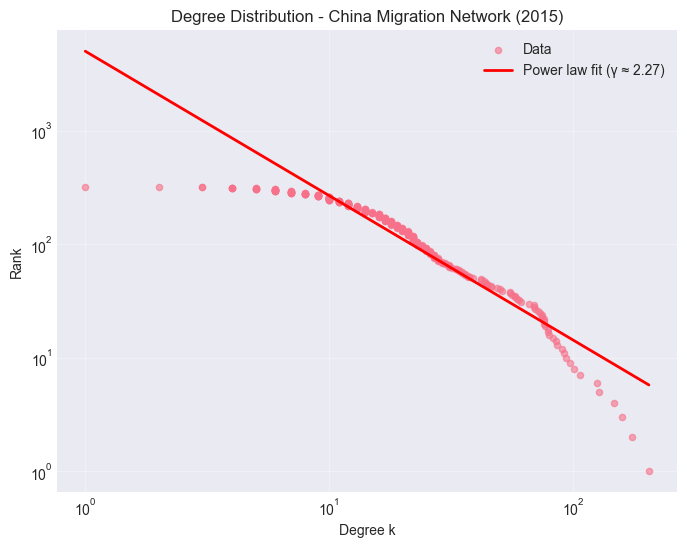

In [122]:
from scipy import stats
from scipy.optimize import curve_fit

# Get degrees only for nodes with valid positions
all_degrees = dict(G_undirected.degree())
degrees = [all_degrees[n] for n in node_list]

# Estimate gamma from degree distribution
degrees_sorted = np.sort(degrees)[::-1]
ranks = np.arange(1, len(degrees_sorted) + 1)

# Fit power law to degree distribution (log-log linear fit)
# P(k) ~ k^(-gamma)
# Use degrees > 5 to avoid small-degree noise
mask = degrees_sorted > 5
if mask.sum() > 10:
    log_degrees = np.log(degrees_sorted[mask])
    log_ranks = np.log(ranks[mask])
    
    slope, intercept = np.polyfit(log_degrees, log_ranks, 1)
    gamma_estimate = -slope + 1  # Convert slope to gamma
else:
    gamma_estimate = 2.5  # Default

# Estimate average degree
avg_degree = np.mean(degrees)
m_estimate = avg_degree / 2

# Estimate temperature from clustering
try:
    clustering = nx.average_clustering(G_undirected, weight='weight')
except:
    clustering = 0.0

# Rough mapping: higher clustering -> lower T (more geometric)
# This is a heuristic; proper inference requires maximum likelihood
T_estimate = max(0.1, min(1.0, 1.0 - clustering))

print(f"\n=== Estimated nPSO Parameters ===")
print(f"  N (nodes with coords): {len(node_list)}")
print(f"  m (avg degree/2): {m_estimate:.2f}")
print(f"  γ (gamma): {gamma_estimate:.2f}")
print(f"  T (temperature): {T_estimate:.2f}")
print(f"  Clustering coefficient: {clustering:.4f}")

# Plot degree distribution with fitted power law
plt.figure(figsize=(8, 6))
plt.scatter(degrees_sorted, ranks, alpha=0.6, s=20, label='Data')
if mask.sum() > 10:
    fitted_ranks = np.exp(intercept) * degrees_sorted**slope
    plt.plot(degrees_sorted, fitted_ranks, 'r-', linewidth=2, 
             label=f'Power law fit (γ ≈ {gamma_estimate:.2f})')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree k')
plt.ylabel('Rank')
plt.title(f'Degree Distribution - China Migration Network ({YEAR})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Map Geographic Coordinates to Hyperbolic Space

We'll map the geographic (lon, lat) to hyperbolic polar coordinates (r, θ).

In [123]:
# Create hyperbolic coordinates with better radial distribution

# Get degrees for nodes with valid coordinates
all_degrees_dict = dict(G_undirected.degree())
node_degrees = {n: all_degrees_dict[n] for n in node_list}

degrees_array = np.array([node_degrees[n] for n in node_list])

print(f"Processing {len(node_list)} nodes with valid coordinates")
print(f"Degree range: {degrees_array.min()} to {degrees_array.max()}")

# Map to polar coordinates
lon_center = coords[:, 0].mean()
lat_center = coords[:, 1].mean()

# Angular coordinate from geographic position
x = coords[:, 0] - lon_center
y = coords[:, 1] - lat_center
theta = np.arctan2(y, x)
theta = (theta + 2*np.pi) % (2*np.pi)

# Radial coordinate: map degree to radius
# Higher degree = closer to center (more important nodes at center)
# Use inverse mapping: r = R * (1 - (k - k_min)/(k_max - k_min))^β
k_min = degrees_array.min()
k_max = degrees_array.max()

if k_max > k_min:
    # Normalize degrees to [0, 1]
    degree_norm = (degrees_array - k_min) / (k_max - k_min)
    # Map to radius: high degree -> small r (center), low degree -> large r (periphery)
    # Use power β to control distribution (β=0.5 spreads points more evenly)
    beta = 0.5
    r_normalized = (1 - degree_norm) ** beta
    # Scale to reasonable hyperbolic radius range [0, 5]
    r_hyperbolic = r_normalized * 5.0
else:
    # All same degree, spread uniformly
    r_hyperbolic = np.ones(len(node_list)) * 2.5

print(f"\nHyperbolic radius (r):")
print(f"  Range: [{r_hyperbolic.min():.3f}, {r_hyperbolic.max():.3f}]")
print(f"  Mean: {r_hyperbolic.mean():.3f}")

# Convert to Poincaré disk for visualization
x_poincare = np.tanh(r_hyperbolic/2) * np.cos(theta)
y_poincare = np.tanh(r_hyperbolic/2) * np.sin(theta)

print(f"\nPoincaré disk coordinates:")
print(f"  x: [{x_poincare.min():.4f}, {x_poincare.max():.4f}]")
print(f"  y: [{y_poincare.min():.4f}, {y_poincare.max():.4f}]")
print(f"  Radius: [{np.sqrt(x_poincare**2 + y_poincare**2).min():.4f}, "
      f"{np.sqrt(x_poincare**2 + y_poincare**2).max():.4f}]")

# Save coordinates
hyperbolic_coords = pd.DataFrame({
    'node': node_list,
    'lon': coords[:, 0],
    'lat': coords[:, 1],
    'r': r_hyperbolic,
    'theta': theta,
    'degree': degrees_array,
    'x_poincare': x_poincare,
    'y_poincare': y_poincare
})

hyperbolic_coords.to_csv(f'china_hyperbolic_coords_{YEAR}.csv', index=False)
print(f"\n✅ Created hyperbolic embedding for {len(node_list)} nodes")

Processing 320 nodes with valid coordinates
Degree range: 1 to 205

Hyperbolic radius (r):
  Range: [0.000, 5.000]
  Mean: 4.662

Poincaré disk coordinates:
  x: [-0.9855, 0.9843]
  y: [-0.9852, 0.9833]
  Radius: [0.0000, 0.9866]

✅ Created hyperbolic embedding for 320 nodes


## 8. Visualize Hyperbolic Embedding

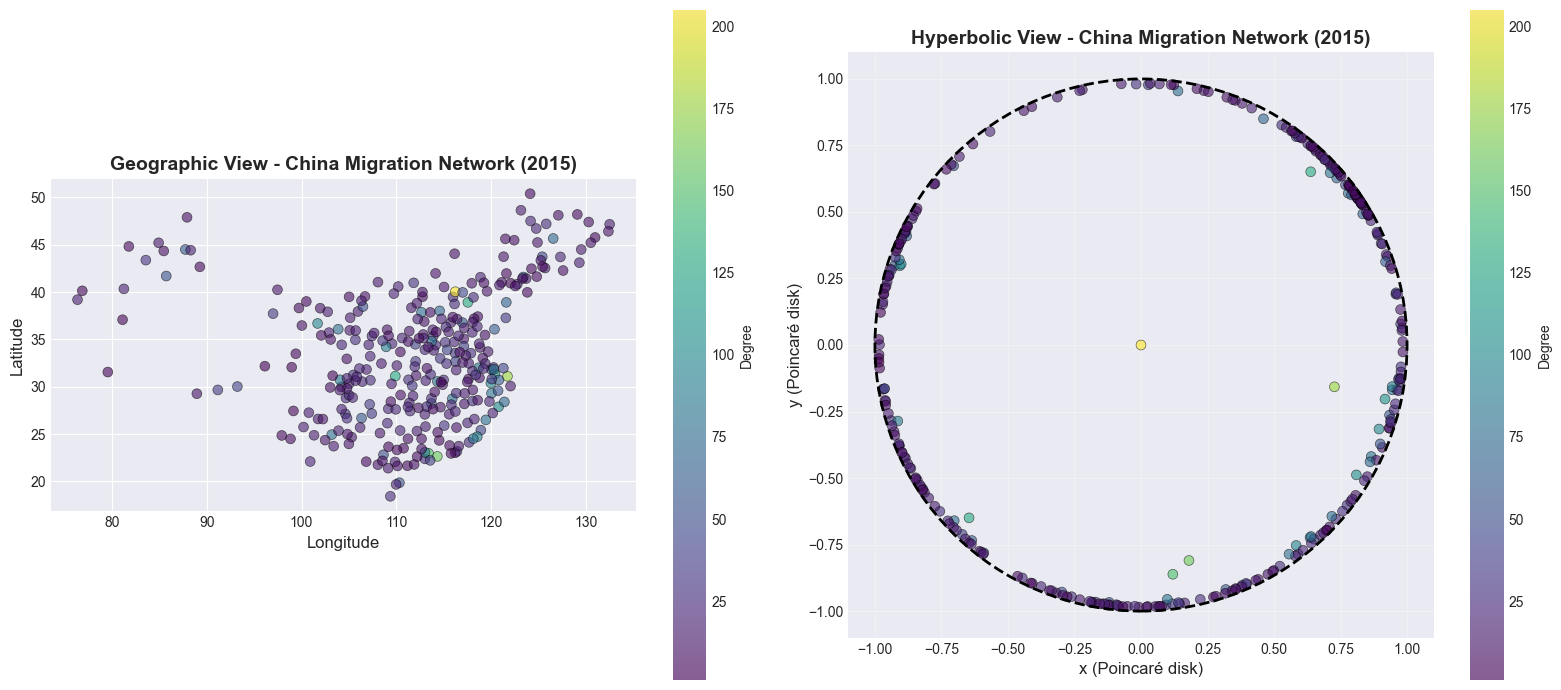

✅ Plotted 320 nodes in both views
✅ Saved to: china_hyperbolic_embedding_2015.png


In [124]:
# Visualize geographic and hyperbolic embeddings

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Left: Geographic view
ax = axes[0]
scatter = ax.scatter(coords[:, 0], coords[:, 1], 
                    c=degrees_array,
                    s=50, alpha=0.6, cmap='viridis', edgecolors='black', linewidth=0.5)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'Geographic View - China Migration Network ({YEAR})', fontsize=14, fontweight='bold')
ax.set_aspect('equal')
plt.colorbar(scatter, ax=ax, label='Degree')

# Right: Hyperbolic view (Poincaré disk)
ax = axes[1]

# Plot points using x_poincare and y_poincare from cell 15
scatter = ax.scatter(x_poincare, y_poincare,
                    c=degrees_array,
                    s=50, alpha=0.6, cmap='viridis', edgecolors='black', linewidth=0.5)

# Draw disk boundary
circle = plt.Circle((0, 0), 1, fill=False, edgecolor='black', linewidth=2, linestyle='--')
ax.add_patch(circle)

ax.set_xlabel('x (Poincaré disk)', fontsize=12)
ax.set_ylabel('y (Poincaré disk)', fontsize=12)
ax.set_title(f'Hyperbolic View - China Migration Network ({YEAR})', fontsize=14, fontweight='bold')
ax.set_aspect('equal')
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Degree')

plt.tight_layout()
plt.savefig(f'china_hyperbolic_embedding_{YEAR}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plotted {len(node_list)} nodes in both views")
print(f"✅ Saved to: china_hyperbolic_embedding_{YEAR}.png")

## 9. Compute Hyperbolic Distances and Connection Probability


Computed 51,040 pairwise distances
Edges present: 3734 (7.32%)


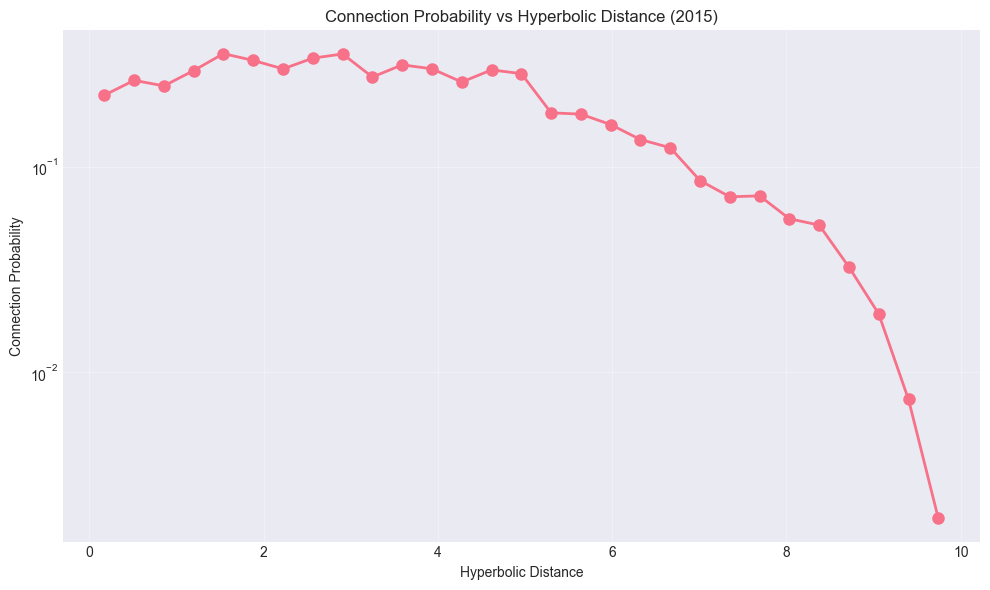


Connection probability decays with hyperbolic distance,
suggesting the network has hyperbolic geometry properties.


In [125]:
def hyperbolic_distance(r1, theta1, r2, theta2):
    """Compute hyperbolic distance between two points in polar coordinates."""
    delta_theta = np.pi - np.abs(np.pi - np.abs(theta1 - theta2))
    return np.arccosh(np.cosh(r1) * np.cosh(r2) - np.sinh(r1) * np.sinh(r2) * np.cos(delta_theta))

# Sample some node pairs to compute distances
sample_size = min(1000, len(node_list))
sample_indices = np.random.choice(len(node_list), sample_size, replace=False)

distances_hyp = []
has_edge = []

for i in range(sample_size):
    for j in range(i+1, sample_size):
        idx_i = sample_indices[i]
        idx_j = sample_indices[j]
        
        d_hyp = hyperbolic_distance(r_hyperbolic[idx_i], theta[idx_i],
                                   r_hyperbolic[idx_j], theta[idx_j])
        distances_hyp.append(d_hyp)
        
        # Check if edge exists
        edge_exists = G_undirected.has_edge(node_list[idx_i], node_list[idx_j])
        has_edge.append(edge_exists)

distances_hyp = np.array(distances_hyp)
has_edge = np.array(has_edge)

print(f"\nComputed {len(distances_hyp):,} pairwise distances")
print(f"Edges present: {has_edge.sum()} ({100*has_edge.mean():.2f}%)")

# Plot distance vs connection probability
plt.figure(figsize=(10, 6))

# Bin by distance
bins = np.linspace(0, distances_hyp.max(), 30)
bin_centers = (bins[:-1] + bins[1:]) / 2
digitized = np.digitize(distances_hyp, bins)

prob_connection = []
for i in range(1, len(bins)):
    mask = digitized == i
    if mask.sum() > 0:
        prob_connection.append(has_edge[mask].mean())
    else:
        prob_connection.append(0)

plt.plot(bin_centers, prob_connection, 'o-', linewidth=2, markersize=8)
plt.xlabel('Hyperbolic Distance')
plt.ylabel('Connection Probability')
plt.title(f'Connection Probability vs Hyperbolic Distance ({YEAR})')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

print(f"\nConnection probability decays with hyperbolic distance,")
print(f"suggesting the network has hyperbolic geometry properties.")

## 10. Summary and Next Steps

### What we've done:
1. ✅ Loaded China migration network for a specific year
2. ✅ Estimated nPSO parameters (γ, T, m) from network statistics
3. ✅ Mapped nodes to hyperbolic coordinates using degree-based radial positions
4. ✅ Visualized the network in both geographic and hyperbolic space
5. ✅ Analyzed connection probability vs hyperbolic distance

### Next steps for more accurate inference:
- Use proper maximum likelihood estimation for γ and T
- Implement Mercator algorithm (requires C++ compilation or running standalone)
- Compare inferred coordinates with geographic coordinates
- Test predictive power of hyperbolic model for link prediction
- Analyze temporal evolution of hyperbolic parameters across different years

In [126]:
# Export summary
summary = {
    'year': YEAR,
    'nodes': G_undirected.number_of_nodes(),
    'edges': G_undirected.number_of_edges(),
    'avg_degree': avg_degree,
    'gamma': gamma_estimate,
    'temperature': T_estimate,
    'm': m_estimate,
    'clustering': clustering,
    'density': nx.density(G_undirected)
}

print("\n=== Final Summary ===")
for key, val in summary.items():
    print(f"  {key}: {val}")

# Save summary
pd.DataFrame([summary]).to_csv(f'china_hyperbolic_summary_{YEAR}.csv', index=False)
print(f"\nSaved summary to: china_hyperbolic_summary_{YEAR}.csv")


=== Final Summary ===
  year: 2015
  nodes: 378
  edges: 4614
  avg_degree: 25.8625
  gamma: 2.2724475149065406
  temperature: 0.9944316945134941
  m: 12.93125
  clustering: 0.0055683054865058425
  density: 0.06475516820344407

Saved summary to: china_hyperbolic_summary_2015.csv
